# Init

In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path
import argparse
import json
import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from semantic_sam import SemanticSAM, semantic_sam_l
from tree_segmentation import Tree3Dv2, Tree3D, TreePredictor, TreeSegmentMetric, Tree2D
from tree_segmentation.util import show_masks, show_all_levels, get_hash_name, image_add_points
from evaluation.eval_PartNet import get_mesh_and_gt_tree, get_images, \
    run_fast_2d_semgentation, predictor_options, get_predictor

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.0+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
glctx = dr.RasterizeCudaContext()
utils.set_printoptions(linewidth=120)

In [4]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
cache_root = Path('~/Projects/Segmentation/TreeSeg/results').expanduser()
# cache_root = Path('/data5/wan/PartNet/Bed/').expanduser()
print(f"Data Root: {data_root}")
shapes = list(os.scandir(data_root))
print(f'There are {len(shapes)} shapes')

Data Root: /home/wan/data/PartNet/data_v0
There are 1457 shapes


In [10]:
# example = data_root.joinpath('12136')
# example = data_root.joinpath('12012')
# example = data_root.joinpath('7254')
example = data_root.joinpath('22835')
# example = data_root.joinpath('1850')
# print(f"Example dir", example)
cache_dir = cache_root.joinpath(get_hash_name(example.joinpath('objs')))
cache_dir.mkdir(exist_ok=True)
print('Cache Dir:', cache_dir)
with example.joinpath('meta.json').open('r') as f:
    meta = json.load(f)
print('meta:', meta)
# with example.joinpath('result_after_merging.json').open('r') as f:
#     meta_parts = json.load(f)
# print(list(os.scandir(example)))
# for item in os.scandir(example):
#     print('=' * 20, item.name, '=' * 20)
#     if item.name.endswith('.json'):
#         with example.joinpath(item.name).open('r') as f:
#             data = json.load(f)
#             print(yaml.dump(data))

Cache Dir: /home/wan/Projects/Segmentation/TreeSeg/results/data_v0_22835_objs
meta: {'model_id': '5554b586330150ab6d5ac6b606b81bbd', 'anno_id': '22835', 'user_id': 'yz_zhangcong', 'time_in_sec': '910', 'version': '2', 'model_cat': 'Table'}


In [11]:
d = utils.eval_str("{SQ: 0.7314, RQ: 0.7749, PQ: 0.5593, TS: 0.9930, TQ: 0.5544, mSQ: 0.9214, mRQ: 0.5210, mPQ: 0.4786, mTS: 0.9953, mTQ: 0.4761, mIoU: 0.5349}")
print(' & '.join(map(str, d.values())))

0.7314 & 0.7749 & 0.5593 & 0.993 & 0.5544 & 0.9214 & 0.521 & 0.4786 & 0.9953 & 0.4761 & 0.5349


In [12]:
if 1 and cache_dir.joinpath(example.stem + '.mesh_cache').exists() and cache_dir.joinpath('gt.tree3dv2').exists():
    mesh = torch.load(cache_dir.joinpath(example.stem + '.mesh_cache'), map_location=device)
    gt = Tree3Dv2(mesh, device=device)
    gt.load(cache_dir.joinpath('gt.tree3dv2'))
else:
    mesh, gt = get_mesh_and_gt_tree(example, cache_dir, device)
print(mesh, gt)
gt.print_tree()

meta: {'model_id': '5554b586330150ab6d5ac6b606b81bbd', 'anno_id': '22835', 'user_id': 'yz_zhangcong', 'time_in_sec': '910', 'version': '2', 'model_cat': 'Table'}
['new-0', 'new-1', 'new-2', 'new-3', 'new-4', 'original-1', 'original-2', 'original-3', 'original-4', 'original-5', 'original-6', 'original-7', 'original-9']
There are 13 parts Mesh(vertices=15182, faces=213)
[Tree] reset
[Tree] Resize tree from 1 to 11
[Tree] Resize tree from 11 to 21
[Tree] Resize tree from 21 to 31
[Tree] reset
[Tree] reset
[Tree] Resize tree from 1 to 21
[Tree] rerange nodes
[Tree3D] Save results to /home/wan/Projects/Segmentation/TreeSeg/results/data_v0_22835_objs/gt.tree3dv2
Save gt result
Mesh(vertices=75979, faces=30568) <tree_segmentation.tree_3d_segmentation.Tree3Dv2 object at 0x7f547bd1c880>


0: Tree Root
├── 1
└── 2
    ├── 3
    ├── 4
    ├── 5
    ├── 6
    ├── 7
    ├── 8
    ├── 9
    ├── 10
    ├── 11
    │   ├── 13
    │   └── 14
    └── 12
        ├── 15
        └── 16

F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024], F32Tensor[100, 4, 4]


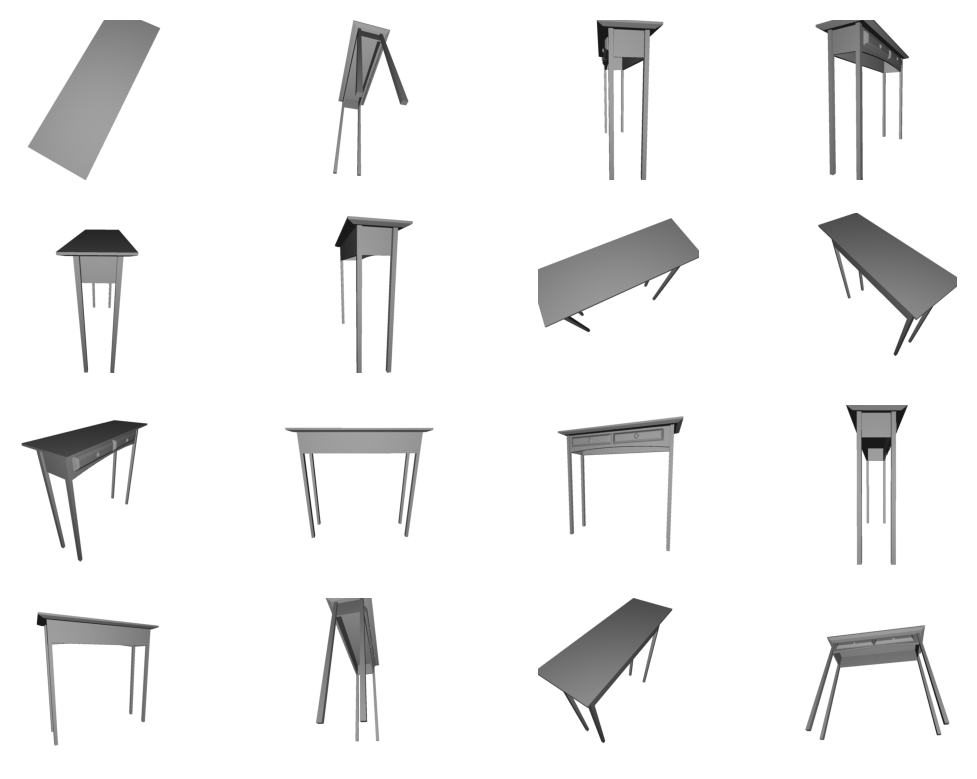

In [13]:
num_views = 100
images, tri_ids, Tw2vs = get_images(glctx, mesh.to(device), image_size=1024, num_views=num_views, seed=42)
images, tri_ids, Tw2vs = images.cpu(), tri_ids.cpu(), Tw2vs.cpu()
print(utils.show_shape(images, tri_ids, Tw2vs))
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

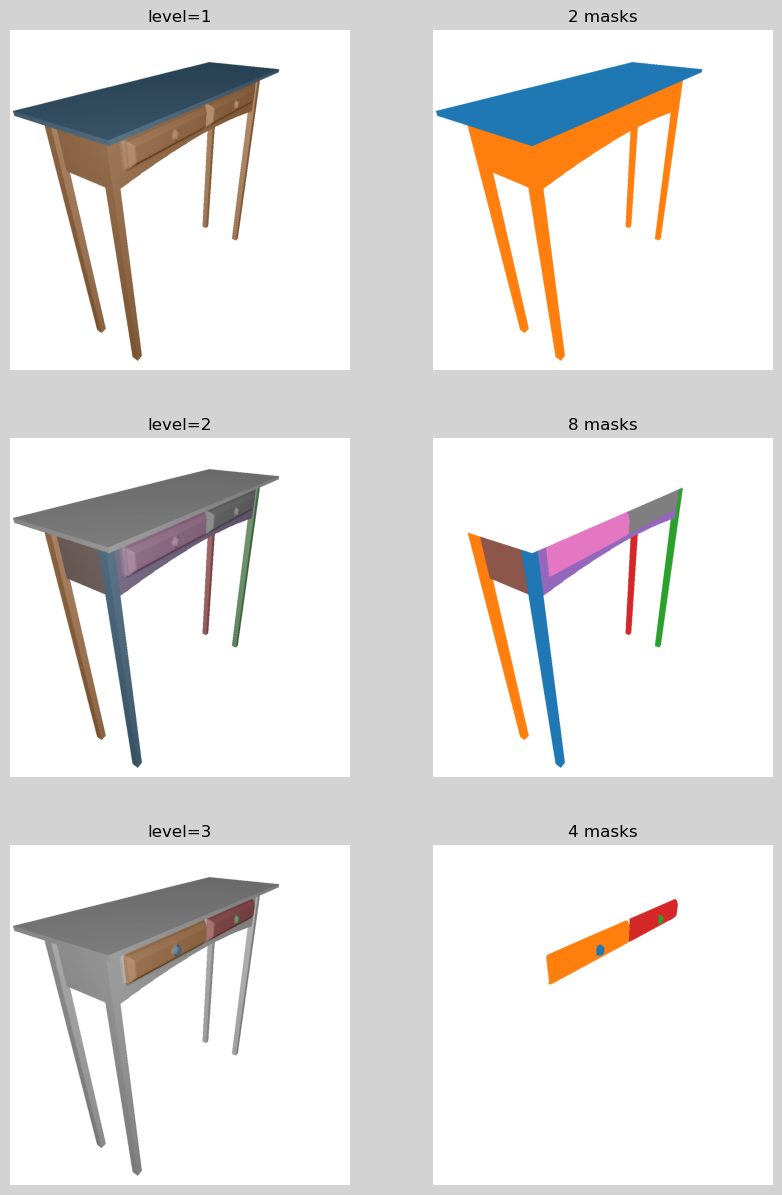

In [14]:
show_index = 8
num_level = show_all_levels(images[show_index, :, :, :3], gt, tri_ids[show_index], facecolor='lightgray')
plt.show()

# Fast Segment 2D

In [26]:
parser =  argparse.ArgumentParser()
predictor_options(parser)
args = parser.parse_args([])
print(args)
predictor = get_predictor(args)

Namespace(box_nms_thresh=0.7, explore_ratio=0.5, image_size=1024, in_area_threshold=50, in_threshold=0.8, max_steps=100, min_area=100, points_per_batch=64, points_per_side=32, points_per_update=256, pred_iou_thresh=0.88, segment_anything=False, segment_anything_b=False, segment_anything_h=False, segment_anything_l=False, semantic_sam_l=False, semantic_sam_t=False, stability_score_thresh=0.95, union_threshold=0.1, weights='./weights')
Loaded Model Semantic-SAM-l
build predictor


image: F32Tensor[1024, 1024, 3]


5

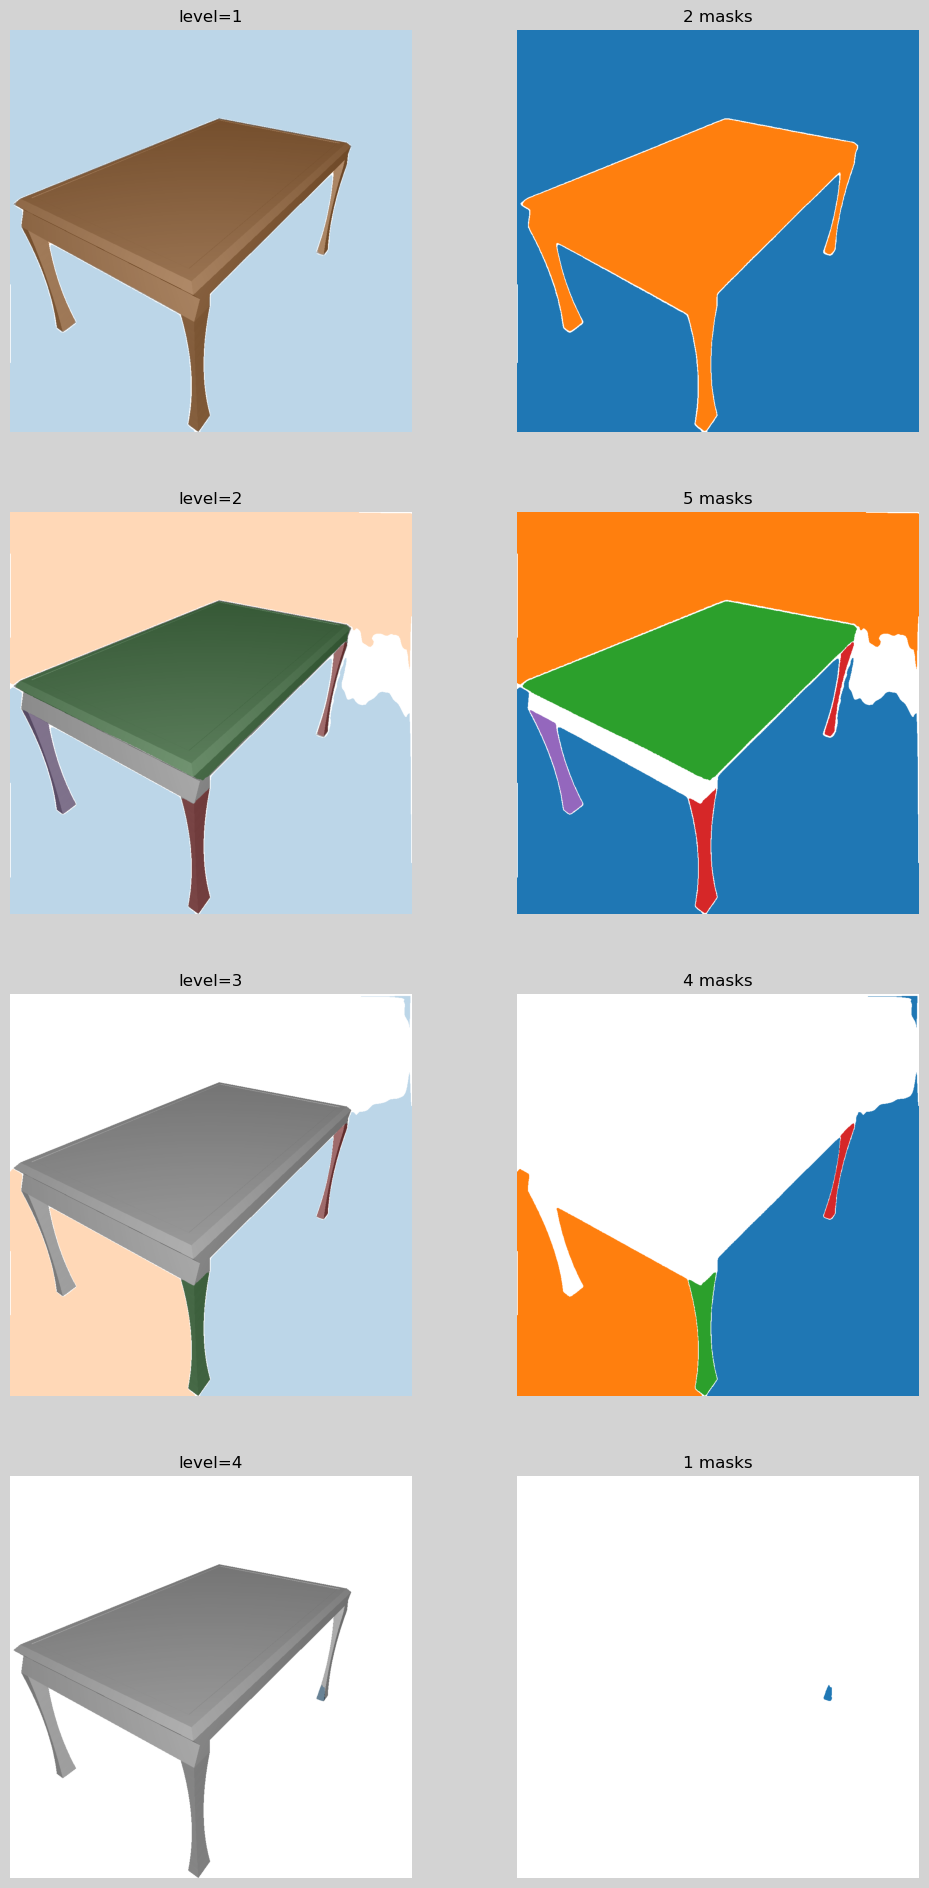

In [11]:
show_index = 8
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.tree_generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_steps=100,
    in_threshold=0.8,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
show_all_levels(image, tree_data, facecolor='lightgray', width=6)

In [ ]:
run_fast_2d_semgentation(cache_dir, mesh, images, tri_ids, Tw2vs, num_points=10, steps=10, predictor=predictor)

In [ ]:
for i in range(num_views):
    data = torch.load(cache_dir.joinpath(f"view_{i:04d}.data"))
    tree2d = Tree2D(device=device)
    tree2d.load(None, data['tree_data'])

In [13]:
def build_view_graph(area, tri_ids: Tensor, threshold=0.5, num_nearest=5):
    N_view = tri_ids.shape[0]
    view_masks = torch.zeros((N_view, area.shape[0] + 1), device=device)
    for i in range(N_view):
        v_faces = tri_ids[i].unique()
        if v_faces[0] == 0:
            v_faces = v_faces[1:]
        view_masks[i, v_faces] = 1
    # print(area.shape)
    A = F.linear(view_masks[:, 1:], view_masks[:, 1:] * area)
    mask_area = torch.mv(view_masks[:, 1:], area)
    # A = A / (area[:, None] + area[None, :] - A).clamp_min(1e-7)
    A = A / mask_area[:, None]
    indices = torch.topk(A, num_nearest + 1, dim=0)[1]
    # print(utils.show_shape(indices))
    A = A.ge(threshold)
    A[torch.arange(N_view), indices] = 1
    return A

In [22]:
v3 = mesh.v_pos[mesh.f_pos]  # shape: (F, 3, 3)
area = torch.cross(v3[:, 0] - v3[:, 1], v3[:, 0] - v3[:, 2], dim=-1).norm(dim=-1) * 0.5
A = build_view_graph(area, tri_ids)

N = 10
images = (images[:, :, :, :3] * 255).to(torch.uint8).cpu().numpy()

In [ ]:
features = []
results = []
# first stage
for i in range(N):
    predictor.set_image(images[i])
    features.append(utils.tensor_to(predictor.features, device=torch.device('cpu')))
    tree2d = Tree2D(
        # device=device,
        # min_area=predictor.generate_cfg.min_area,
        # in_threshold=predictor.generate_cfg.in_threshold,
        # in_thres_area=predictor.generate_cfg.in_area_threshold,
        # union_threshold=predictor.generate_cfg.union_threshold,
    )
    points = tree2d.sample_grid()#predictor.generate_cfg.points_per_side)
    output = predictor.process_points(points)
    print({k for k, v in output.items()})
    num_ignored = tree2d.insert_batch(output)
    tree2d.remove_not_in_tree()
    tree2d.compress()
    # predictor.reset_image()
    results.append(tree2d)
    print('dealed', i)

A[0, 4]=True
A[0, 6]=True
A[0, 7]=True
A[0, 8]=True
A[0, 9]=True


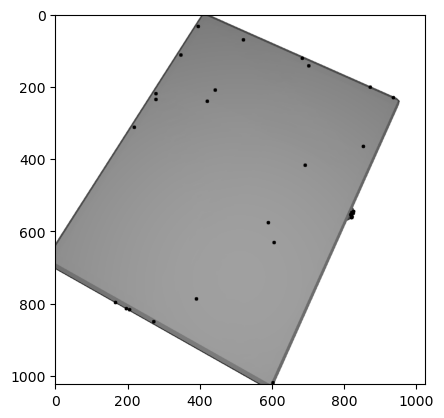

In [43]:
# predictor.set_image(images[0])
for i in range(N):
    points = []
    # in_view = torch.zeros(area.shape[0]+1, dtype=torch.bool, device=device)
    # in_view[tri_ids[i].unique()] = 1
    for j in range(N):
        if i == j or A[i, j] <= 0:
            continue
        print(f'A[{i}, {j}]={A[i, j]}')
        tri_id_j = tri_ids[j] # * in_view[tri_ids[j]]
        results[j].remove_background(tri_ids[j].eq(0))
        for l, x in enumerate(results[j].get_levels()):
            if l == 0:
                continue
            temp = torch.zeros(area.shape[0]+1, dtype=torch.int, device=device)
            for k in x:
                temp[torch.unique(tri_ids[j][results[j].masks[k-1]].to(device))]=k
            temp[0] = 0
            mask = temp[tri_ids[i]]
            # print(l)
            # show_masks(images[i], mask=mask)
            # plt.show()
            for k in x:
                mask_k = torch.nonzero(mask == k)
                if len(mask_k)>0:
                    points.append(mask_k[torch.randint(0, len(mask_k), (2, ))])
    _, H, W = tri_ids.shape
    points = torch.cat(points, dim=0).flip(1) .cpu().numpy() / np.array([W, H])
    plt.imshow(image_add_points(images[i], points))
    plt.show()
    # break
    predictor.features = utils.tensor_to(features[i], device=device)
    results[i].insert_batch(predictor.process_points(points))
    results[i].remove_not_in_tree()
    results[i].compress()
    break




# Slow Segment 2D

In [27]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(num_views)):
    if 1 and cache_dir.joinpath(f"view_{index:04d}.data").exists():
        data = torch.load(cache_dir.joinpath(f"view_{index:04d}.data"), map_location='cpu')
        assert torch.all(data['tri_id'].eq(tri_ids[index].cpu()))
    else:
        tree_data = predictor.tree_generate(
            (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
            max_steps=100,
            in_threshold=0.8,
            union_threshold=0.1,
            min_mask_region_area=100,
            points_per_update=256,
            device=device,
            in_thre_area=50,
            verbose=1,
        )
        data = {
            'tree_data': tree_data.save(filename=None),
            'tri_id': tri_ids[index].clone(),
            'image': images[index].clone(),
            'Tw2v': Tw2vs[index].clone(),
        }
        torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)
    # break

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:49<00:00, 10.10s/it]


0: Tree Root
└── 1
    ├── 2
    └── 3
        └── 4

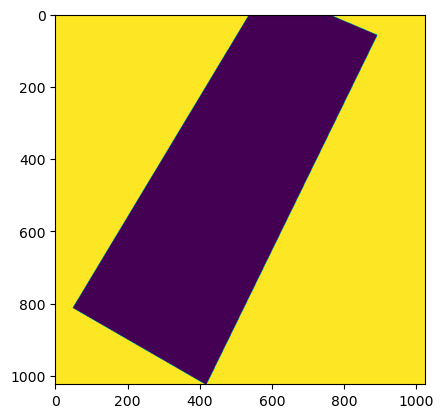

0: Tree Root

True


1

<Figure size 1000x0 with 0 Axes>

In [28]:
show_index = 0
data = torch.load(cache_dir.joinpath(f"view_{show_index:04d}.data"))
tree_data = Tree2D(device=device)
tree_data.load(None, **data['tree_data'])
tree_data.print_tree()
plt.imshow(tri_ids[show_index].eq(0).cpu().numpy())
plt.show()
tree_data.remove_background(tri_ids[show_index].eq(0).to(device))
tree_data.print_tree()
print(isinstance(tree_data, Tree2D))
show_all_levels(images[show_index, :, :, :3], tree_data)

# Check Code Bug

In [11]:
from tree_segmentation import Tree3Dv2
tree3d = Tree3Dv2(mesh, device=device)
tree3d.load_2d_results(cache_dir, pack=True)
# tree3d.build_gt_segmentation(gt, tri_ids)
masks_2d_1 = tree3d.masks_2d
print('masks_2d_1:', masks_2d_1.shape)
print(tree3d.range_2d[:10])

tree3d.reverse_masks_2d_pack()
masks_2d_2 = tree3d.masks_2d
print('masks_2d_2:', masks_2d_2.shape)

tree3d.reverse_masks_2d_pack(threshold=0.9)
masks_2d_3 =tree3d.masks_2d
print('masks_2d_3:', masks_2d_3.shape)
# print(tree3d.range_level[:10])
assert (masks_2d_1.shape == masks_2d_3.shape )
print((masks_2d_1 - masks_2d_3).abs().max())


tree3d.reverse_masks_2d_pack(threshold=0.9)
masks_2d_4 =tree3d.masks_2d
print('masks_2d_4:', masks_2d_4.shape)
assert (masks_2d_2.shape == masks_2d_4.shape )
print((masks_2d_2 - masks_2d_4).abs().max())

[Tree3D] GPU: (3.1355810165405273, 31.7391357421875)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'parent': IntTensor[13], 'first': IntTensor[13], 'next': IntTensor[13], 'last': IntTensor[13], 'cnt': 12, 'num_samples': IntTensor[13], 'masks': IntTensor[6, 1024, 1024], 'scores': F16Tensor[12], 'extra': {}}, 'tri_id': IntTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 3], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] Load 100 views
[Tree3D] GPU: (0.01077890396118164, 31.7391357421875)
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 54938], (IntTensor[19983], LongTensor[19983])
[Tree3D] loaded 100 views, 982 masks, max_num: 15
[Tree3D] GPU: (1.235748291015625, 31.7391357421875)
masks_2d_1: torch.Size([423, 54938])
[(0, 1), (1, 3), (3, 5), (5, 7), (7, 9), (9, 10), (10, 11), (11, 13), (13, 16), (16, 19)]
torch.Size([423, 54938]) torch.Size([982, 54938]) 100
masks_2d_2: torch.Size([982, 54938])
masks_2d_3: torch.Size([423, 54938])
tensor(0, device='cuda:0', dtype=torch.int32)
torch.Size([4

In [12]:
print(torch.nonzero((masks_2d_1 - masks_2d_3)))

tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)


In [15]:
# check build graph between pack and unpack
A1 = tree3d.build_all_graph()
print('A1:', tree3d._masks_2d_packed)
tree3d.reverse_masks_2d_pack()
A2 = tree3d.build_all_graph()
print('A2:', tree3d._masks_2d_packed)
print(utils.show_shape(tree3d.masks_2d, tree3d.indices_2d))
print('cmp:', (A1[:tree3d.M, tree3d.M:]-A2[:tree3d.M, tree3d.M:]).aminmax())
print('diff', (A1-A2).aminmax())
# plt.figure(figsize=(10, 10))
# plt.imshow((A1-A2).abs().cpu().numpy())

A1: True
torch.Size([423, 54938]) torch.Size([982, 54938]) 100
A2: False
F32Tensor[982, 54938], None
cmp: torch.return_types.aminmax(
min=tensor(    -0.0000, device='cuda:0'),
max=tensor(    0.0000, device='cuda:0'))
diff torch.return_types.aminmax(
min=tensor(    -0.0000, device='cuda:0'),
max=tensor(    0.0000, device='cuda:0'))


In [17]:
# check loss functions
K = 2 * tree3d.Lmax
S = torch.randn((tree3d.M, K), device=device)
Sn = torch.randn((K,), device=device)
weights = dict(edge=0, match=0.3, mv=1, recon=0, t2d=3, tree=3, vm=3)
timer = utils.TimeWatcher()
loss_dict1 = tree3d.calc_losses(S.float(), Sn, 0, A1, progress=1., timer=timer, weights=weights)
print(timer)
timer.reset()
tree3d.reverse_masks_2d_pack()
loss_dict2 = tree3d.calc_losses(S.float(), Sn, 0, A1, progress=1., timer=timer, weights=weights)
print(timer)
for k, v in loss_dict1.items():
    print(k, (v-loss_dict2[k]).abs().max())

get masks: 11.4ms, t2d: 1.23ms, match score: 4.78ms, view-masks: 0.67ms, masks-view: 0.92ms, tree loss: 0.58ms
torch.Size([423, 54938]) torch.Size([982, 54938]) 100
get masks: 37.3ms, t2d: 1.28ms, match score: 0.54ms, view-masks: 0.63ms, masks-view: 0.83ms, tree loss: 0.54ms
t2d tensor(0.0088, device='cuda:0')
match tensor(0., device='cuda:0')
vm tensor(    0.0000, device='cuda:0')
mv tensor(    0.0000, device='cuda:0')
tree tensor(    0.0000, device='cuda:0')


# 3D Tree Segmentaion

In [29]:
from tree_segmentation import Tree3Dv2

timer = utils.TimeWatcher()
timer.start()
tree3d = Tree3Dv2(mesh, device=device)
timer.log('new')
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir, pack=False)
timer.log('load 2d')
# Gv = tree3d.build_view_graph()
# timer.log('Gv')
# Gm = tree3d.build_graph(Gv)
# timer.log('Gm')
A = tree3d.build_all_graph()
timer.log('A')
print(utils.show_shape(tree3d.masks_2d, tree3d.masks_view, tree3d.area))
X, autoencoder = tree3d.compress_masks(epochs=3000)
timer.log('X')
print(autoencoder)
print(timer)

[Tree3D] GPU: (9.295145988464355, 31.7391357421875)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'parent': IntTensor[5], 'first': IntTensor[5], 'next': IntTensor[5], 'last': IntTensor[5], 'cnt': 4, 'num_samples': IntTensor[5], 'masks': IntTensor[3, 1024, 1024], 'scores': F16Tensor[4], 'extra': {}}, 'tri_id': IntTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 3], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] Load 100 views
[Tree3D] GPU: (1.915001392364502, 31.7391357421875)
[Tree3D] load 2d results: view 0 no vaild masks
[Tree3D] view_masks, view_infos[0]: BoolTensor[99, 30568], (IntTensor[9260], LongTensor[9260])
[Tree3D] loaded 99 views, 1367 masks, max_num: 24
[Tree3D] GPU: (3.238410472869873, 31.7391357421875)
F32Tensor[1367, 30568], BoolTensor[99, 30568], F32Tensor[30568]
[Tree3D] X epoch[   0], loss: recon= 0.711, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.207, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.067, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.052, 

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
K = tree3d.Lmax * 2
kwargs = dict(in_channels=X.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm')
gnn = pyg.nn.GCN(**kwargs).to(device)
# gnn = pyg.nn.GAT(**kwargs, edge_dim=1).to(device)
print(gnn)
# print(A.diag())
# A.fill_diagonal_(0.)
tree3d.run(epochs=5000, K=K, gnn=gnn, A=A , X=X, topP=False, weights=dict(
        vm=0,
        mv=0,
        t2d=1,
        tree=1,
        match=1,
        view=1,
        recon=0,
    ))
tree3d.save(cache_dir.joinpath('my.tree3dv2'))
# 4m16.6s

GCN(256, 48, num_layers=2)
[Tree3D] GPU: (3.1696958541870117, 31.7391357421875)
[Tree3D] GPU: (2.882032871246338, 31.7391357421875)
[Tree3D] Epoch 100: loss=2.323544, t2d= 0.169, match= 0.880, view= 0.354, tree= 1.954
[Tree3D] Epoch 200: loss=2.138548, t2d= 0.164, match= 0.857, view= 0.351, tree= 0.792
[Tree3D] Epoch 300: loss=1.733535, t2d= 0.150, match= 0.829, view= 0.352, tree= 0.605
[Tree3D] Epoch 400: loss=1.833093, t2d= 0.140, match= 0.814, view= 0.337, tree= 0.530
[Tree3D] Epoch 500: loss=0.917754, t2d= 0.137, match= 0.818, view= 0.345, tree= 0.481
[Tree3D] Epoch 600: loss=1.640442, t2d= 0.132, match= 0.823, view= 0.340, tree= 0.436
[Tree3D] Epoch 700: loss=1.647868, t2d= 0.133, match= 0.818, view= 0.363, tree= 0.399
[Tree3D] Epoch 800: loss=1.519815, t2d= 0.127, match= 0.809, view= 0.321, tree= 0.364
[Tree3D] Epoch 900: loss=1.519792, t2d= 0.125, match= 0.805, view= 0.336, tree= 0.349
[Tree3D] Epoch 1000: loss=1.548009, t2d= 0.140, match= 0.779, view= 0.321, tree= 0.337
[Tree3D

tensor([0.9024, 0.0000, 0.8144, 0.7509, 0.7214, 0.7059, 0.0000, 0.6524, 0.4910, 0.4641, 0.3867, 0.3725, 0.2996, 0.0000,
        0.2829, 0.2760, 0.2460, 0.2099, 0.1978, 0.1904, 0.1903, 0.1720, 0.1708, 0.1624, 0.1599, 0.1546, 0.1525, 0.1489,
        0.1470, 0.1054, 0.0993, 0.0981, 0.0979, 0.0775, 0.0773, 0.0734, 0.0722, 0.0660, 0.0630, 0.0594, 0.0489, 0.0465,
        0.0435, 0.0432, 0.0401, 0.0391, 0.0382, 0.0351], device='cuda:0')


0: Tree Root
├── 5
├── 4
├── 3
└── 1

BoolTensor[48, 30569]
SQ 0.0
RQ 0.0
PQ 0.0
TS 1.0
TQ 0.0
mIoU 0.024723879992961884


'SQ 0.7792490005493165\nRQ 0.45454545454545453\nPQ 0.3542040911587802\nTS 0.9018175601959229\nTQ 0.3194274693002254\nmIoU 0.5903344750404358'

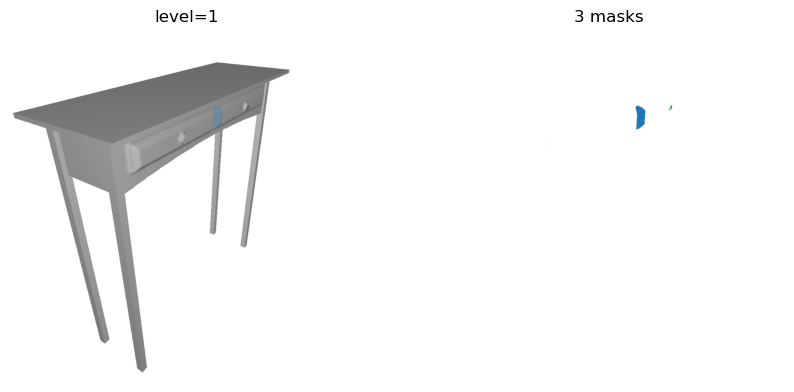

In [35]:
print(tree3d.scores)
# tree3d.set_score_threshold(0.5)
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()
print(utils.show_shape(tree3d.masks))
# tree3d.save(cache_dir.joinpath('my.tree3dv2'))

from tree_segmentation.metric import TreeSegmentMetric

metric = TreeSegmentMetric()
metric.update(tree3d.to(device), gt.to(device))
for k, v in metric.summarize().items():
    print(k, v)
"""SQ 0.7792490005493165
RQ 0.45454545454545453
PQ 0.3542040911587802
TS 0.9018175601959229
TQ 0.3194274693002254
mIoU 0.5903344750404358"""

# 3D Tree Segmentation use GT 2D results

In [15]:
from tree_segmentation.tree_3d_segmentation import Tree3Dv2

tree3d_gt = Tree3Dv2(mesh, device, verbose=1)
tree3d_gt.load_2d_results(gt=gt, tri_ids=tri_ids)
# Gv_ = tree3d_gt.build_view_graph()
# Gm_ = tree3d_gt.build_graph(Gv_)
A_ = tree3d_gt.build_all_graph()
X_, autoencoder = tree3d_gt.compress_masks(epochs=3000)
print(autoencoder)
# print(utils.show_shape(Gv_, Gm_, X_))
print(utils.show_shape(A_, X_))

[Tree] reset
[Tree3D] GPU: (3.1350483894348145, 31.7391357421875)
[Tree3D] Load 100 views
[Tree3D] GPU: (0.010155200958251953, 31.7391357421875)
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 30568], (IntTensor[2], LongTensor[2])
[Tree3D] loaded 100 views, 992 masks, max_num: 14
[Tree3D] GPU: (1.2010760307312012, 31.7391357421875)
[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.710, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.202, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.065, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.047, lr=9.754e-04
[Tree3D] X epoch[ 400], loss: recon= 0.041, lr=9.566e-04
[Tree3D] X epoch[ 500], loss: recon= 0.038, lr=9.328e-04
[Tree3D] X epoch[ 600], loss: recon= 0.034, lr=9.043e-04
[Tree3D] X epoch[ 700], loss: recon= 0.032, lr=8.714e-04
[Tree3D] X epoch[ 800], loss: recon= 0.031, lr=8.343e-04
[Tree3D] X epoch[ 900], loss: recon= 0.028, lr=7.937e-04
[Tree3D] X epoch[1000], loss: rec

In [20]:
K = gt.cnt * 2
kwargs = dict(in_channels=X_.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm')
gnn = pyg.nn.GCN(**kwargs)
# gnn = pyg.nn.GAT(**kwargs, edge_dim=1)
gnn = gnn.to(device)
print(gnn)

tree3d_gt.run(
    epochs=5000,
    K=K,
    gnn=gnn,
    A=A_,
    X=X_,
    weights=dict(
        vm=1,
        mv=1,
        t2d=0,
        tree=1,
        match=1,
        view=0,
        recon=1,
    ))
# tree3d_gt.save(cache_dir.joinpath('gt_seg.tree3dv2'))


GCN(256, 32, num_layers=2)
[Tree3D] GPU: (1.1855072975158691, 31.7391357421875)
[Tree3D] GPU: (1.1065192222595215, 31.7391357421875)
[Tree3D] Epoch 100: loss=2.648545, recon= 0.082, match= 0.785, vm= 0.842, mv= 0.255, tree= 1.378
[Tree3D] Epoch 200: loss=2.261413, recon= 0.072, match= 0.611, vm= 0.712, mv= 0.211, tree= 0.598
[Tree3D] Epoch 300: loss=2.109269, recon= 0.074, match= 0.534, vm= 0.631, mv= 0.194, tree= 0.507
[Tree3D] Epoch 400: loss=1.943874, recon= 0.071, match= 0.522, vm= 0.623, mv= 0.194, tree= 0.461
[Tree3D] Epoch 500: loss=1.777775, recon= 0.068, match= 0.452, vm= 0.577, mv= 0.180, tree= 0.454
[Tree3D] Epoch 600: loss=1.591430, recon= 0.056, match= 0.372, vm= 0.526, mv= 0.161, tree= 0.443
[Tree3D] Epoch 700: loss=1.410077, recon= 0.057, match= 0.268, vm= 0.474, mv= 0.137, tree= 0.418
[Tree3D] Epoch 800: loss=1.162483, recon= 0.055, match= 0.248, vm= 0.444, mv= 0.128, tree= 0.407
[Tree3D] Epoch 900: loss=1.014985, recon= 0.049, match= 0.176, vm= 0.391, mv= 0.104, tree= 

In [22]:
tree3d_gt.save(cache_dir.joinpath('gt_seg.tree3dv2'))
print(tree3d_gt.scores, tree3d_gt)

[Tree3D] Save results to /home/wan/Projects/Segmentation/TreeSeg/data_v0_1850_objs/gt_seg.tree3dv2
tensor([0.9293, 0.8809, 0.8782, 0.8697, 0.8571, 0.8554, 0.8385, 0.8340, 0.7801, 0.7293, 0.6273, 0.5737, 0.2798, 0.1651,
        0.1650, 0.1264, 0.1209, 0.1050, 0.0835, 0.0701, 0.0588, 0.0581, 0.0525, 0.0102], device='cuda:0') <tree_segmentation.tree_3d_segmentation.Tree3Dv2 object at 0x7fb72d3e1b20>


tensor([0.9316, 0.9077, 0.8800, 0.8752, 0.8701, 0.8586, 0.8558, 0.8133, 0.7981, 0.7965, 0.7963, 0.7668, 0.0000, 0.7007,
        0.6390, 0.2684, 0.2394, 0.1893, 0.1784, 0.1203, 0.1041, 0.0913, 0.0903, 0.0544, 0.0527, 0.0508, 0.0432, 0.0428,
        0.0408, 0.0306, 0.0278, 0.0206], device='cuda:0')


0: Tree Root
├── 15
│   ├── 1
│   │   └── 7
│   ├── 2
│   ├── 3
│   ├── 4
│   ├── 6
│   ├── 8
│   ├── 9
│   │   └── 11
│   ├── 10
│   ├── 12
│   └── 14
└── 5

SQ 0.9838688714163644
RQ 0.9333333333333333
PQ 0.9182776133219401
TS 0.9234834313392639
TQ 0.848014161272575
mIoU 0.9814296364784241


'SQ 0.9949123859405518\nRQ 0.7619047619047619\nPQ 0.7580284845261346\nTS 0.8590781688690186\nTQ 0.6512057224372688\nmIoU 0.8973085284233093\n\nSQ 0.9949123859405518\nRQ 0.7619047619047619\nPQ 0.7580284845261346\nTS 0.8590781688690186\nTQ 0.6512057224372688\nmIoU 0.8973085284233093\n'

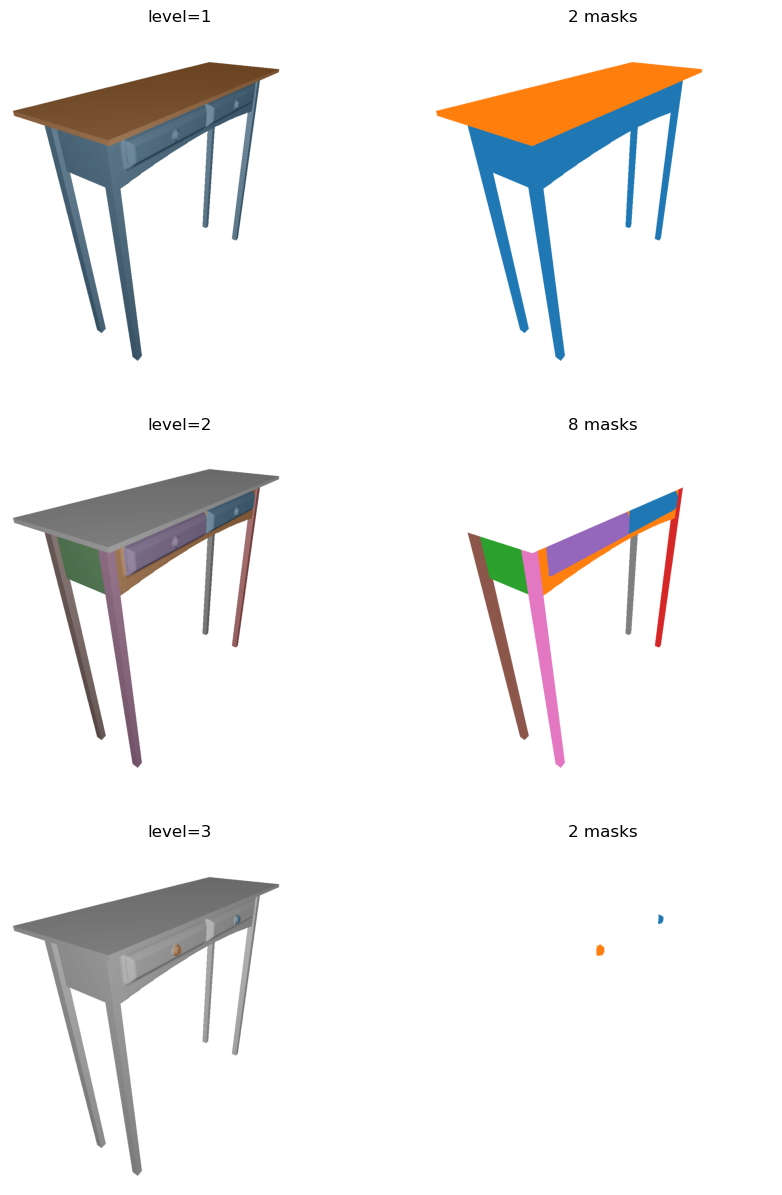

In [21]:
print(tree3d_gt.scores)
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d_gt, tri_ids[show_index])
# tree3d_gt.node_rearrange()
tree3d_gt.print_tree()
metric = TreeSegmentMetric()
metric.update(tree3d_gt.to(device), gt.to(device))
for k, v in metric.summarize().items():
    print(k, v)
# without tree loss: 0.5807471451935945 0.4203405976295471
# with tree loss:0.733435549054827 0.5524243116378784
#                                    PQ      TQ    mTQ    mIoU
# [recon + match + vm + mv + tree]: 0.8307 0.8304 0.5245 0.9265
# [recon + match + vm      + tree]: 0.8336 0.8335 0.5321 0.9298
# [recon + match           + tree]: 0.4149 0.4109 0.2976 0.7683
# [      + match + vm      + tree]: 0.8331 0.8330 0.5299 0.9293
# [recon + match + vm            ]: 0.7220 0.7213 0.4840 0.8515
"""SQ 0.9949123859405518
RQ 0.7619047619047619
PQ 0.7580284845261346
TS 0.8590781688690186
TQ 0.6512057224372688
mIoU 0.8973085284233093

SQ 0.9949123859405518
RQ 0.7619047619047619
PQ 0.7580284845261346
TS 0.8590781688690186
TQ 0.6512057224372688
mIoU 0.8973085284233093
"""

# Other Attempt

In [ ]:
@torch.enable_grad()
def run(Adj: Tensor, Attr: Tensor, t: Tree3Dv2, epochs=5000):
    gnn = pyg.nn.GCN(
        in_channels=X_.shape[1], hidden_channels=128, num_layers=2, out_channels=128, norm='BatchNorm').cuda()

    opt = torch.optim.Adam(gnn.parameters(), lr=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, epochs, 1e-6)

    edges = torch.nonzero(Adj).T
    edge_weights = Adj[edges[0], edges[1]]
    print(utils.show_shape(edges, edge_weights))

    for epoch in range(epochs):
        opt.zero_grad()
        view_index = torch.randint(0, t.N_view, (1,)).item()
        view_mask = t.view_infos[view_index][0]
        print('view_mask', utils.show_shape(view_mask))
        features = gnn(Attr, edges, edge_weight=edge_weights)
        print(utils.show_shape(features))
        start_index, end_index = t.view_range[view_index]
        for u in range(start_index, end_index):
            linked = edges[1, edges[0] == u]
            scores = 1 - F.relu(-torch.mv(features[linked], features[u]))  # shape: [Nu]
            linked = F.pad(linked, (0, 1), value=u)
            scores = F.pad(scores, (0, 1), value=1)  # TODO: 权重参数化
            mask_u = scores @ t.face_masks[linked]  # shape: [Nu, F]
            print(utils.show_shape(scores, linked, t.view_masks[t.view_indices[linked]], mask_u))
            mask_u = mask_u / (scores @ t.view_masks[t.view_indices[linked]]).clamp_min(1e-7)
            mask_u = mask_u[view_mask]
            print((mask_u - t.face_masks[u, view_mask]).abs().sum())
            diff = F.mse_loss(mask_u, t.face_masks[u, view_mask])  # to FocalLoss
            print(utils.show_shape(mask_u), diff)
            # print(u, utils.show_shape(linked, scores), linked, scores)
        opt.step()
        lr_scheduler.step()
        break


run(Gm_ * (Gm_ >= 0.5), X, tree3d_gt)

# Simple Merge

In [ ]:
my = Tree3Dv2(mesh, device=device)
my.build_gt_segmentation(gt, tri_ids)
my.build_graph(my.build_view_graph())

In [ ]:
def get_score(tree: Tree3Dv2, indices: Tensor, Mask: Tensor = None):
    if not isinstance(indices, Tensor):
        indices = torch.tensor(indices, device=tree.device)
    view_mask_ = tree.view_masks[tree.view_indices[indices], 1:]
    masks_ = tree.face_masks[indices, 1:]
    # print(utils.show_shape(indices, view_mask_, masks_))
    if Mask is None:
        Mask = (masks_.sum(dim=0) / view_mask_.sum(dim=0).clamp_min(1e-7)) >= 0.5
    masks_M = Mask[None, :] * view_mask_
    area_M = torch.mv(masks_M, tree.area)
    area_m = torch.mv(masks_, tree.area)
    inter = (masks_M * masks_ * tree.area).sum(dim=1)
    iou = inter / (area_m + area_M - inter).clamp_min(1e-7)
    # print(iou)
    return iou.mean()


# assert 0 <= my.face_masks.min() and my.face_masks.max() <= 1., my.face_masks.aminmax()
def run_simple_merge(tree: Tree3Dv2, threshold=0.9, num_min=2):
    visited = torch.zeros(tree.M, device=tree.device, dtype=torch.bool)
    masks = []

    for i in range(tree.M):
        if visited[i]:
            continue
        visited[i] = True
        mask = tree.face_masks[i].clone()
        cnt = tree.view_masks[tree.view_indices[i]].clone()
        que = [i]

        while True:
            update = False
            for k in range(tree.M):
                if not visited[k] and (tree.A[que, k] >= 0.5).any():
                    mask_k, cnt_k = tree.face_masks[k], tree.view_masks[tree.view_indices[k]]
                    mask_ = (mask + mask_k) / (cnt + cnt_k).clamp_min(1e-7) >= 0.5
                    score = get_score(tree, que + [k], mask_[1:])
                    # print(f'k={k}, score={score}')
                    if score > threshold:
                        que.append(k)
                        visited[k] = True
                        mask += mask_k
                        cnt += cnt_k
                        update = True
                        break
            if not update:
                break
        if len(que) >= num_min:
            mask = mask / cnt.clamp_min(1e-7) >= 0.5
            score = get_score(tree, que, mask[1:])
            masks.append((que, mask, score))
            print(f'Number: {len(que)}, score={score}')
    tree.resize(len(masks) + 1)
    scores, indices = torch.sort(torch.stack([x[2] for x in masks]), descending=True)
    tree.masks = torch.stack([x[1] for x in masks])[indices]
    tree.scores = scores
    tree.masks_area = tree.masks[:, 1:].float() @ tree.area
    print(utils.show_shape(tree.masks, tree.masks_area, tree.scores))
    tree.set_score_threshold(threshold)
    return masks


def run_simple_merge_2(tree: Tree3Dv2, threshold=0.9, num_min=2):
    is_obj = torch.ones(tree.M, device=tree.device, dtype=torch.bool)
    A = tree.A.clone()  # type: Tensor
    masks = tree.face_masks.clone()  # type: Tensor
    cnts = tree.view_masks[tree.view_indices]
    merge = {i: [i] for i in range(tree.M)}
    print(utils.show_shape(masks, cnts, A))
    # for uv in torch.nonzero(A):
    #     u, v = uv.tolist()
    #     A[u, v] = get_score(tree, [u, v])

    while Tree:
        indices = torch.argmax(A).item()
        u, v = indices // A.shape[1], indices % A.shape[1]
        # print(f'u={u}, v={v}, iou={A[u, v]}')
        if A[u, v] < threshold:
            break
        # merge u, v
        merge[u] = merge[u] + merge.pop(v)
        is_obj[v] = False
        masks[u] += masks[v]
        cnts[u] += cnts[v]
        # update A
        indices = (A[u, :] > 0) | (A[v, :] > 0)
        indices[u] = False
        indices[v] = False
        A[v, :] = 0
        A[:, v] = 0
        for w in torch.nonzero(indices):
            w = w.item()
            mask = ((masks[u] + masks[w]) / (cnts[u] + cnts[w]).clamp_min(1e-7)) >= 0.5
            A[u, w] = A[w, u] = get_score(tree, merge[u] + merge[w], mask[1:])
        # view_masks = tree.view_masks[tree.view_indices[indices], 1:]
        # masks_e = masks[indices, 1:] * view_masks
        # mask = (masks[u]  / cnts[u].clamp_min(1e-7)) >= 0.5
        # mask = mask[None, 1:] * view_masks
        # # print('masks:', utils.show_shape(masks, masks_e))
        # area_u = torch.mv(mask, tree.area)
        # area_e = torch.mv(masks_e, tree.area)
        # # print('area:', utils.show_shape(area_e, area_u))
        # inter = torch.mv(masks_e * mask, tree.area)
        # iou = inter / (area_u + area_e - inter).clamp_min(1e-7)
        # # print('iou:', utils.show_shape(iou, inter))
        # # print(iou)
        # A[u, indices] = iou
        # A[indices, u] = iou
        # # break
        # return

    masks = (masks[is_obj] / cnts[is_obj].clamp_min(1e-7)) >= 0.5
    scores = []
    for i in torch.nonzero(is_obj):
        indices = merge[i.item()]
        if len(indices) < num_min:
            continue
        scores.append(get_score(tree, indices))
    scores, indices = torch.sort(torch.tensor(scores, device=masks.device), descending=True)
    print('score, masks', utils.show_shape(scores, masks))
    print('num:', [len(v) for k, v in merge.items() if len(v) >= num_min])
    tree.cnt = 0
    tree.resize(len(masks) + 1)
    tree.masks = masks[indices]
    tree.scores = scores
    tree.masks_area = tree.masks[:, 1:].float() @ tree.area
    print(utils.show_shape(tree.masks, tree.masks_area, tree.scores))
    tree.set_score_threshold(threshold)
    return scores

In [ ]:
my = Tree3Dv2(mesh, device=device)
my.build_gt_segmentation(gt, tri_ids)
my.build_graph(my.build_view_graph())

run_simple_merge(my)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my, tri_ids[show_index])
my.print_tree()
metric = TreeSegmentMetric()
metric.update(my.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# 0.7612818479537964 0.44708824157714844

In [ ]:
run_simple_merge_2(my, threshold=0.9)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my, tri_ids[show_index])
my.print_tree()
metric = TreeSegmentMetric()
metric.update(my.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# use score (0.9): 0.8394677562098349 0.5187289118766785
# use score (0.8): 0.8401441881733556 0.5180656313896179
# use IoU: 0.5285388484145656 0.2708543539047241

In [ ]:
my2 = Tree3Dv2(mesh, device=device)
my2.load_2d_results(cache_dir)
my2.build_graph(my2.build_view_graph())

run_simple_merge(my2, threshold=0.8)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my2, tri_ids[show_index])
my2.print_tree()
metric = TreeSegmentMetric()
metric.update(my2.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# 0.15785423590212452 0.08242347091436386

In [ ]:
run_simple_merge_2(my2, threshold=0.8)
show_index = 8
show_all_levels(images[show_index, :, :, :3], my2, tri_ids[show_index])
my2.print_tree()
metric = TreeSegmentMetric()
metric.update(my2.to(device), gt.to(device))
print(metric.PQ, metric.TQ)
# 0.17959821419637712 0.11583688855171204

# V-M Graph

In [9]:
tree3d_gt = ts.Tree3Dv2(mesh, device, verbose=1)
tree3d_gt.build_gt_segmentation(gt, tri_ids)

[Tree] reset
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 30569], (IntTensor[2], LongTensor[2])
[Tree3D] loaded 100 views, 1082 masks, max_num: 16


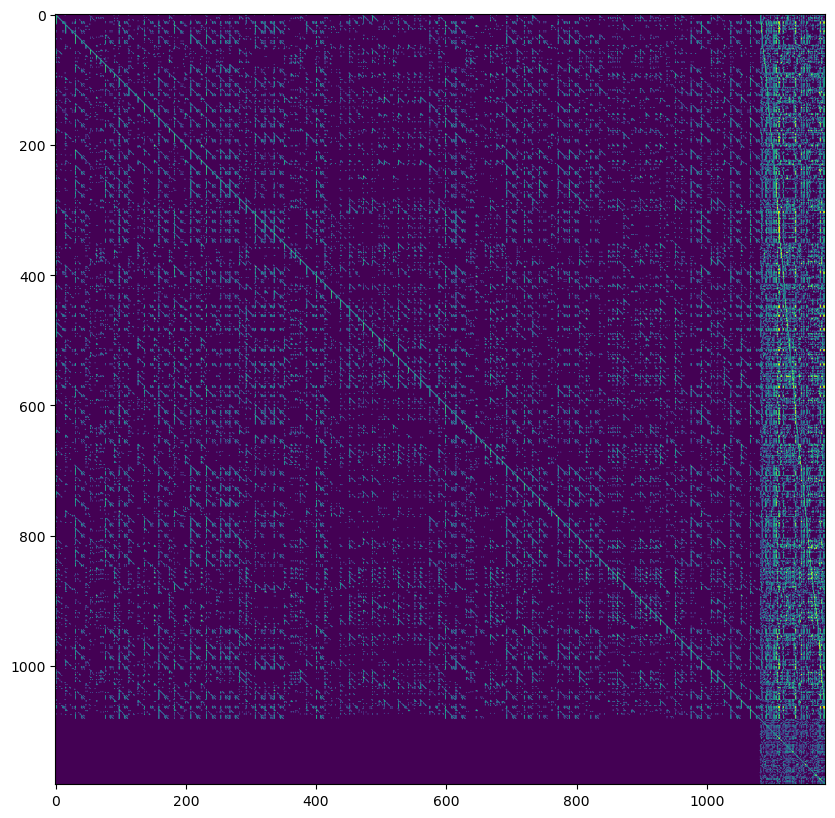

In [35]:
V = tree3d_gt.V
M = tree3d_gt.M
N = M + V
A = torch.zeros((N, N), device=device)
# view-view
area = torch.mv(tree3d_gt.masks_view[:, 1:].float(), tree3d_gt.area)
A[M:, M:] = F.linear(tree3d_gt.masks_view[:, 1:].float(), tree3d_gt.masks_view[:, 1:] * tree3d_gt.area) / area[:, None]
# view-mask
areas_m = torch.mv(tree3d_gt.masks_2d[:, 1:], tree3d_gt.area)
A[:M, M:] = F.linear(tree3d_gt.masks_2d[:, 1:], tree3d_gt.masks_view[:, 1:].float() * tree3d_gt.area) / areas_m[:, None]
# mask-mask
A[:M, :M] = F.linear(tree3d_gt.masks_2d[:, 1:], tree3d_gt.masks_2d[:, 1:].float() * tree3d_gt.area) / areas_m[:, None]

plt.figure(figsize=(10, 10))
plt.imshow((A * (A > 0.5)).cpu().numpy())
plt.show()

In [27]:
X, _ = tree3d_gt.compress_masks(epochs=3000, include_views=True)

[Tree3D] X epoch[   0], loss: recon= 0.711, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.192, lr=9.972e-04
[Tree3D] X epoch[ 200], loss: recon= 0.061, lr=9.890e-04
[Tree3D] X epoch[ 300], loss: recon= 0.045, lr=9.754e-04
[Tree3D] X epoch[ 400], loss: recon= 0.039, lr=9.566e-04
[Tree3D] X epoch[ 500], loss: recon= 0.034, lr=9.328e-04
[Tree3D] X epoch[ 600], loss: recon= 0.031, lr=9.043e-04
[Tree3D] X epoch[ 700], loss: recon= 0.030, lr=8.714e-04
[Tree3D] X epoch[ 800], loss: recon= 0.028, lr=8.343e-04
[Tree3D] X epoch[ 900], loss: recon= 0.026, lr=7.937e-04
[Tree3D] X epoch[1000], loss: recon= 0.023, lr=7.498e-04
[Tree3D] X epoch[1100], loss: recon= 0.022, lr=7.032e-04
[Tree3D] X epoch[1200], loss: recon= 0.020, lr=6.544e-04
[Tree3D] X epoch[1300], loss: recon= 0.019, lr=6.038e-04
[Tree3D] X epoch[1400], loss: recon= 0.017, lr=5.522e-04
[Tree3D] X epoch[1500], loss: recon= 0.016, lr=5.000e-04
[Tree3D] X epoch[1600], loss: recon= 0.016, lr=4.478e-04
[Tree3D] X epoch[1700], loss: r

In [33]:
K = gt.cnt * 2
gnn = pyg.nn.GCN(in_channels=X.shape[1], hidden_channels=128, num_layers=2, out_channels=K, norm='BatchNorm').cuda()
print(gnn)

tree3d_gt.run(epochs=5000, K=K, gnn=gnn, A=A * (A > 0.5), X=X)
# tree3d_gt.save(cache_dir.joinpath('gt_seg.tree3dv2'))

GCN(256, 32, num_layers=2)
[Tree3D] GPU: (1.766345500946045, 11.904052734375)
[Tree3D] GPU: (1.5089354515075684, 11.904052734375)
[Tree3D] Epoch 100: loss=1.516580, match= 0.718, mm= 0.770, tree= 0.069
[Tree3D] Epoch 200: loss=1.361184, match= 0.584, mm= 0.642, tree= 0.063
[Tree3D] Epoch 300: loss=0.401151, match= 0.576, mm= 0.615, tree= 0.060
[Tree3D] Epoch 400: loss=1.311932, match= 0.482, mm= 0.553, tree= 0.060
[Tree3D] Epoch 500: loss=0.982518, match= 0.478, mm= 0.542, tree= 0.063
[Tree3D] Epoch 600: loss=0.923642, match= 0.481, mm= 0.518, tree= 0.064
[Tree3D] Epoch 700: loss=0.324845, match= 0.433, mm= 0.470, tree= 0.063
[Tree3D] Epoch 800: loss=1.059690, match= 0.427, mm= 0.454, tree= 0.061
[Tree3D] Epoch 900: loss=1.180794, match= 0.439, mm= 0.444, tree= 0.059
[Tree3D] Epoch 1000: loss=0.816962, match= 0.408, mm= 0.428, tree= 0.058
[Tree3D] Epoch 1100: loss=1.145740, match= 0.429, mm= 0.413, tree= 0.057
[Tree3D] Epoch 1200: loss=0.774964, match= 0.422, mm= 0.411, tree= 0.058
[Tr

0: Tree Root
├── 12
├── 10
└── 8
    ├── 20
    ├── 16
    ├── 2
    ├── 4
    └── 7
        └── 1

SQ 0.44549698299831814
RQ 0.72
PQ 0.3207578277587891
TS 0.9874051213264465
TQ 0.3167179226875305
mSQ 0.633765459060669
mRQ 0.21609601378440857
mPQ 0.17469418048858643
mTS 0.9913851618766785
mTQ 0.1726098358631134
mIoU 0.570273220539093


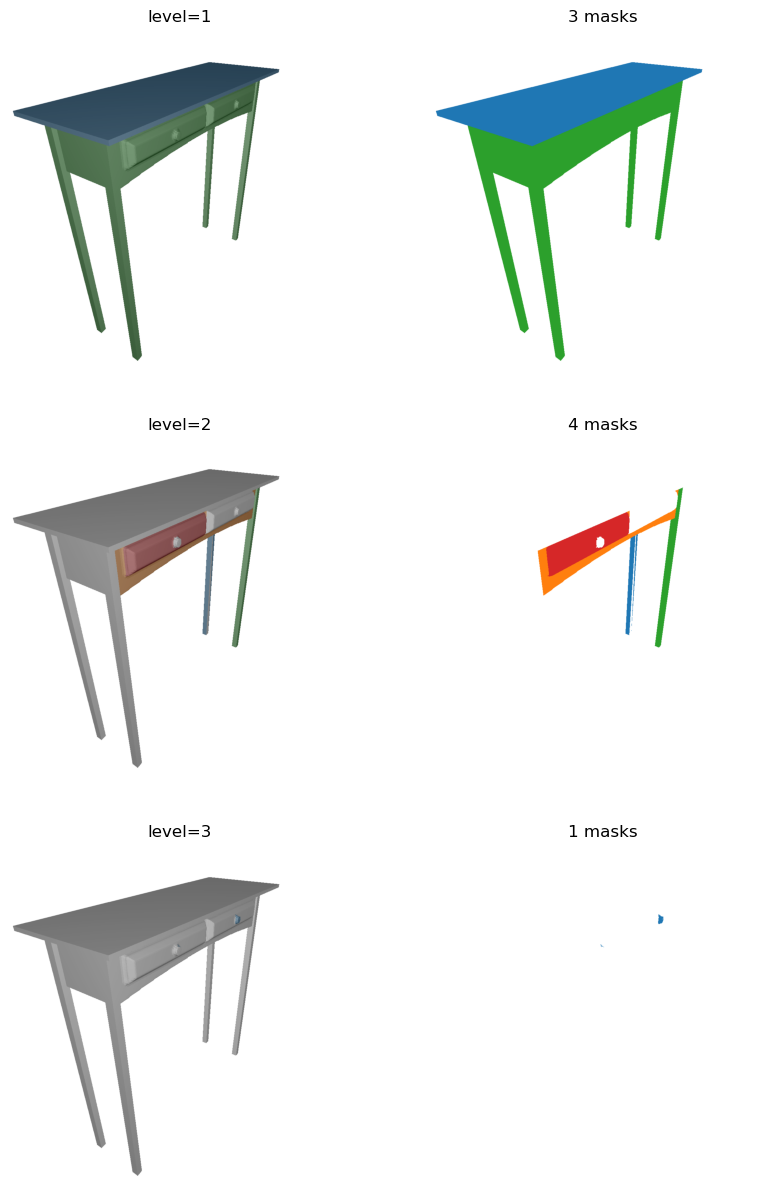

In [34]:
# tree3d_gt.in_threshold = 0.9
# tree3d_gt.set_score_threshold(0.7)
show_index = 8
show_all_levels(images[show_index, :, :, :3], tree3d_gt, tri_ids[show_index])
# tree3d_gt.node_rearrange()
tree3d_gt.print_tree()
metric = TreeSegmentMetric()
metric.update(tree3d_gt.to(device), gt.to(device))
for k, v in metric.summarize().items():
    print(k, v)
# without tree loss: 0.5807471451935945 0.4203405976295471
# with tree loss:0.733435549054827 0.5524243116378784